# **Case Study: Feasibility of Auto-Adjudication**

**M. Kayumov**

### **Task**
Based on the existing data set: 
- perform an EDA, 
- create ML models that could be used as a basis for auto-adjudication,
- establish guidelines for auto-adjudication, 
- analyse the financial impact of auto-adjudicationtion, 
- analyse the value (tangible & intangible) of the project, 
- provide recommendations.

# **Executive Summary** 

The analysis shows that auto-adjudication might yield significant benefits for  the bank:

- reduce the mortgages adjudication workload on credit officers by 2/3; 
- improve accuracy of credit decisions and spot potential defaulting requests in close to 100% cases;
- meet the growth challenge in the reverse mortgages space that might continue at the double-digit levels for the coming 5 years; 
- create close to USD 4 mln of additional shareholder value.

Based on these points, our **recommendation** is to consider launching the project in the next 2-3 months to secure a dominant space for the bank in the reverse mortgages market for the coming period of booming growth.



# **Exploratory Data Analysis**

This analysis is based on the data provided to us by the bank directly. The data set contains no PI II data and therefore can be processed and stored without encryption. 

In [ ]:
# Work with google drive 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load analytical packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load machine learning packages 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Load statistical packages 

import statsmodels.api as sm

np.random.seed(12345)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import the excel file and call it xls_file
excel_file_1 = pd.ExcelFile('/content/drive/MyDrive/reverse_mortgages/Portfolio_Data_for_case_study.xlsx')
   
# Load the excel_file's Sheet1 as a dataframe
mortgages_data = excel_file_1.parse('2017')

**Note:** After importing the data from XLSX format, we parse the sheet (2017) that contains the data we are interested in. Below is a summary of the data presented in the dataset.

In [ ]:
# Check the info 

mortgages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595 entries, 0 to 3594
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   File Number               3595 non-null   int64         
 1   POA / Influencer          3595 non-null   object        
 2   Property Type             3595 non-null   object        
 3   City                      3595 non-null   object        
 4   Province                  3595 non-null   object        
 5   client age3               3590 non-null   float64       
 6   Credit Score              3586 non-null   float64       
 7   Monthly income            3595 non-null   float64       
 8   First Appraisal Date      3595 non-null   datetime64[ns]
 9   First Appraisal Value     3595 non-null   int64         
 10  Funded Date               3595 non-null   datetime64[ns]
 11  Days To Fund              3595 non-null   int64         
 12  Total Approved Amoun

As the summary above shows, we deal with 3595 rows of data split into 14 columns. 

Below is a preview of the dataset.

In [ ]:
# Preview the dataset 

mortgages_data.head(5)

,File Number,POA / Influencer,Property Type,City,Province,client age3,Credit Score,Monthly income,First Appraisal Date,First Appraisal Value,Funded Date,Days To Fund,Total Approved Amount,Most Recent Default Date
0,2223,No,"Detached Duplex, Triplex, or Quadruplex",Ottawa,Ontario,64.228571,782.0,1800.0,2017-11-02,435000,2017-11-24,13,108750.0,NaT
1,2224,No,Single Family Dwelling,Virden,Manitoba,64.000000,683.0,2400.0,2017-10-30,315000,2017-12-18,40,78750.0,NaT
2,2225,No,Single Family Dwelling,Keswick,Ontario,64.000000,816.0,2500.0,2017-11-09,990000,2017-12-01,36,247500.0,NaT
3,2226,Yes,Condo - Townhouse/Stacked Townhouse,Langley,British Columbia,89.264368,759.0,2778.0,2017-12-06,588000,2017-12-21,27,147000.0,2019-03-27
4,2227,No,Single Family Dwelling,Westbank,British Columbia,64.228571,0.0,7337.0,2016-12-22,460000,2017-02-15,56,115000.0,NaT


At this point, we should examine the dataset to identify any potential problems with it, such as missing or duplicate values.

In [ ]:
# Show a sum of duplicates in the dataset

print(f'The dataset contains {mortgages_data.duplicated(keep=False).sum()} duplicated values.')

The dataset contains 0 duplicated values.


As the report above reads, the dataset contains 0 duplicated values.

In [ ]:
# Write a function to check for missing values

def nan_checker(data_set): 

    summary = {}
    # are there any nan values?
    any_nans = data_set.isna().any().any()
    
    summary['NaNs Exist'] = any_nans
    
    # how many?
    n_nans = data_set.isna().sum().sum()
    summary['NaN Count'] = n_nans
    
    # which variables do they come from
    nan_column_series = data_set.isna().sum()
    nan_column_names = list(nan_column_series[nan_column_series > 0].index)
    
    summary['NaN Containing Columns'] = nan_column_names
    
    
    # any variables with more than 50% of data missing?
    nan_column_percent = 100 * nan_column_series/data_set.shape[0]
    nan_columns_with_more_than_50_pct = list(nan_column_percent[nan_column_percent > 50].index)
    
    summary['NaNs More Than 50%'] = nan_columns_with_more_than_50_pct
    
    #summary can be all the info about nans
    return(summary)

Let's execute the above function to check for missing values.

In [ ]:
# Run the function to check missing values 

nan_checker(mortgages_data)

{'NaN Containing Columns': ['client age3',
  'Credit Score',
  'Most Recent Default Date'],
 'NaN Count': 3090,
 'NaNs Exist': True,
 'NaNs More Than 50%': ['Most Recent Default Date']}

**Observation:** As expected, we only have missing values in the columns related to the client age, credit score and the most recent default date. In total, there are 3090 missing values. 

Let's count the missing values in the mentioned columns separately. 

For that, we should create a report that would reflect the count of missing values for each column, the name of the column and the data type.

In [ ]:
# Create a report that shows the count of missing values for each column

def missing_values_report_mortgages():

  # create a list of columns with missing values 

    list_missing = list(mortgages_data.isnull().sum()[mortgages_data.isnull().sum() != 0].index)

# create a dictionary containing the names and the description of columns with missing values 

    dict_descr = {            'name_column': [
                              "File Number             ",
                              "POA / Influencer        ",
                              "Property Type           ",
                              "City                    ",
                              "Province                ",
                              "client age3             ",
                              "Credit Score            ",
                              "Monthly income          ",
                              "First Appraisal Date    ",
                              "First Appraisal Value   ",
                              "Funded Date             ",
                              "Days To Fund            ",
                              "Total Approved Amount   ",
                              "Most Recent Default Date"]}
    name_column = []
    data_type = []
    mis_vals_count = []

    for column in list_missing:
      if mortgages_data[column].isnull().sum() > 0:
        name_column.append(column)
        data_type.append(mortgages_data[column].dtype) 
        mis_vals_count.append(mortgages_data[column].isnull().sum())

    null_dtypes_val_mortgages_data = pd.DataFrame(data=list(zip(name_column, data_type, mis_vals_count)), columns=['name_column', 'data_type', 'mis_vals_count'])

    from operator import index
    dict_df = pd.DataFrame.from_dict(dict_descr)
    null_dtypes_val_mortgages_data = null_dtypes_val_mortgages_data.merge(dict_df, on = 'name_column', how = 'left')
    return(null_dtypes_val_mortgages_data)

Now that the reporting function has been created and back-tested, we can use it to run a report on our actual data.

In [ ]:
# Show the report reflecting the count of missing values, the name of the columnn and the data type

missing_values_report_mortgages()

,name_column,data_type,mis_vals_count
0,client age3,float64,5
1,Credit Score,float64,9
2,Most Recent Default Date,datetime64[ns],3076


# **Handling the missing values**

**Age:** the number of missing values in the client age column is small, therefore we can impute data using the median of the client age, because it will fit the decimal format of the rest of the values in this column.

In [ ]:
# Impute the age values 

mortgages_data['client age3'] = mortgages_data['client age3'].fillna(mortgages_data['client age3'].median())

**Credit Score:** To understand how we should treat the missing credit score values, we will isolate the rows containing those values and examine them visually.

In [ ]:
# Isolate the rows of the dataset in which Credit Score is missing

mortgages_data[mortgages_data['Credit Score'].isnull()]

,File Number,POA / Influencer,Property Type,City,Province,client age3,Credit Score,Monthly income,First Appraisal Date,First Appraisal Value,Funded Date,Days To Fund,Total Approved Amount,Most Recent Default Date
195,2418,No,Condo - Apartment Style,Vancouver,British Columbia,81.649351,NaN,1800.0,2017-05-17,2198000,2017-06-29,35,549500.0,NaT
530,2753,No,Single Family Dwelling,Richmond Hill,Ontario,91.603448,NaN,1800.0,2016-09-28,1025000,2017-03-09,114,256250.0,NaT
587,2810,No,Single Family Dwelling,Toronto,Ontario,87.205298,NaN,1800.0,2017-04-15,685000,2017-05-03,142,171250.0,NaT
712,2935,No,Stratified SFD/Bare Land Strata,Mississauga,Ontario,75.480370,NaN,0.0,2016-10-28,460000,2017-02-03,55,115000.0,NaT
1110,3333,No,Single Family Dwelling,King City,Ontario,71.902240,NaN,1800.0,2017-07-11,3750000,2017-08-01,185,937500.0,NaT
2146,4369,No,Single Family Dwelling,Markham,Ontario,71.902240,NaN,1800.0,2016-11-02,1220000,2017-01-06,80,305000.0,NaT
2225,4448,No,Single Family Dwelling,Port Dover,Ontario,75.480370,NaN,1800.0,2016-12-23,936000,2017-06-16,155,234000.0,NaT
2492,4715,No,Single Family Dwelling,New Ross,Nova Scotia,68.546939,NaN,1800.0,2017-05-10,126000,2017-05-30,15,31500.0,NaT
3471,5694,No,Single Family Dwelling,Kleinburg,Ontario,84.014851,NaN,1800.0,2017-05-02,2400000,2017-08-02,226,600000.0,NaT


Based on the above, we cannot say whether the credit score is missing because they have no credit (which is unlikely given the senior age and the ownership of real estate), or their credit score is missing for technical reasons.

But since they are only 0.25% of the total volume of data we may safely drop these rows without any damage to the quality of the dataset.

In [ ]:
# Drop rows with missing credit scores 

mortgages_data = mortgages_data.dropna(subset=['Credit Score'])

**Most Recent Default Date:** 

We aren't worried about the "Most Recent Default Date" having missing values because these missing values indicate the 'no default' status. We will use this column as our target. Firstly, we will duplicate the column to keep the date, and, secondly, we will replace the missing values with 0 ('no default'), and the dates will be replaced with 1 ('default') in the new duplicated column that will eventually represent the Y (the value we want to be able to predict).

# **Distribution of Categorical Variables**

### File Number

This column refers to the internal file number of the bank, and it is not relevant for the modelling purposes, so it can be safely dropped.

In [ ]:
mortgages_data = mortgages_data.drop(columns = 'File Number', axis = 1)

### POA / Influencer, Property Type, Province

These are categorical variables. Let's study their distribution to learn is we can obtain any insight from that. 

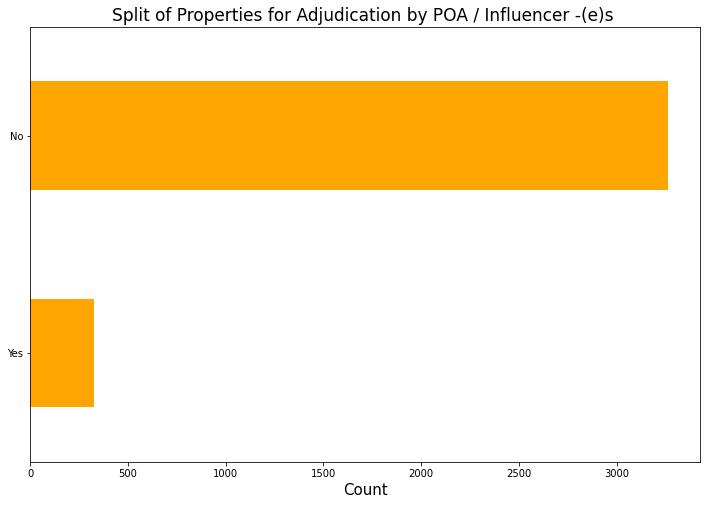

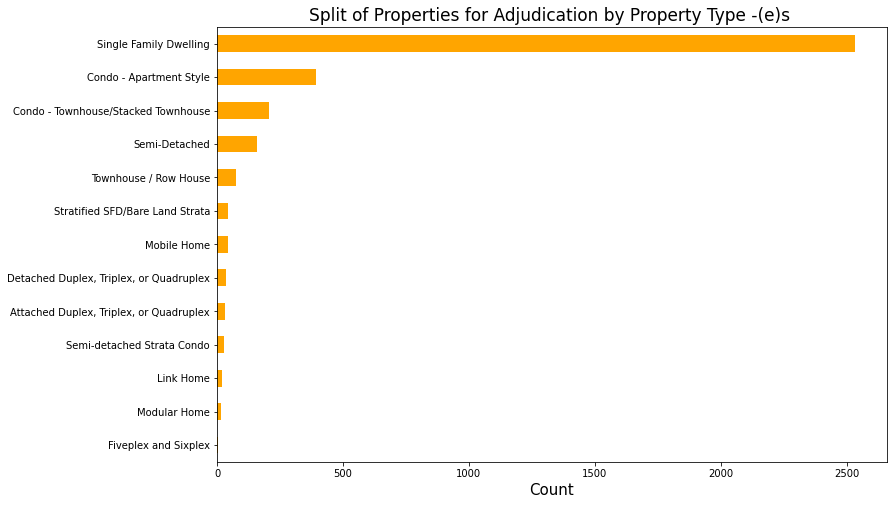

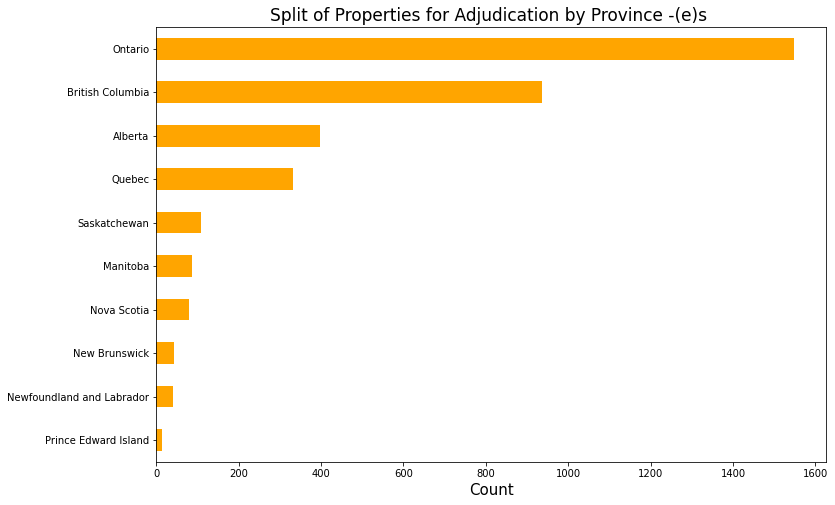

In [ ]:
# check the distribution POA / Influencer, Property Type, Province

for i in ['POA / Influencer', 'Property Type', 'Province']:

  plt.figure(figsize=(12, 8))
  mortgages_data[i].value_counts().sort_values().plot(kind='barh',color='orange')
  plt.title(f'Split of Properties for Adjudication by {i} -(e)s ', size = 17)
  plt.xlabel('Count', size = 15)
  plt.show()


**Observations:**

The plots above demonstrate the distribution of 'POA / Influencer', 'Property Type', 'Province', and the following can be mentioned:
- the majority of the clients requested a mortgage directly from the bank directly; 
- Single-family dwellings and condo apartments are the two most frequently refinanced types of real estate;
- ON, BC and AB are the three leading provinces in terms of the number of clients for us.


### City

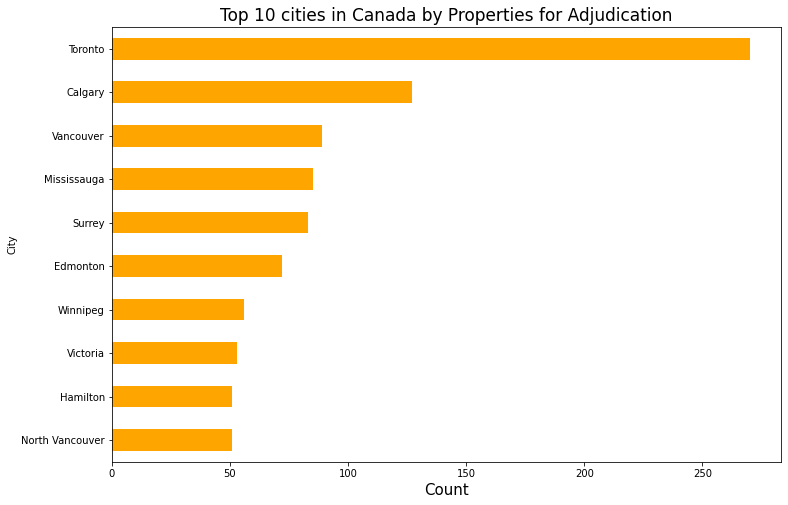

In [ ]:
# Check the distribution City

plt.figure(figsize=(12, 8))
mortgages_data.groupby('City').Province.count().sort_values(ascending=True).tail(10).plot(kind='barh',color='orange')
plt.title(f'Top 10 cities in Canada by Properties for Adjudication', size = 17)
plt.xlabel('Count', size = 15)
plt.show()

**Observation:**
- GTA and Vancouver are the top agglomerations in Canada in reverse mortgage requests.
- AB's Calgary and Edmonton are also among the top 10.

### Distribution of Numerical variables



In [ ]:
# Identify numerical variables 

numerical_variables = ['client age3',	'Credit Score',	'Monthly income',	'First Appraisal Value',	'Days To Fund',	'Total Approved Amount']

<Figure size 432x288 with 0 Axes>

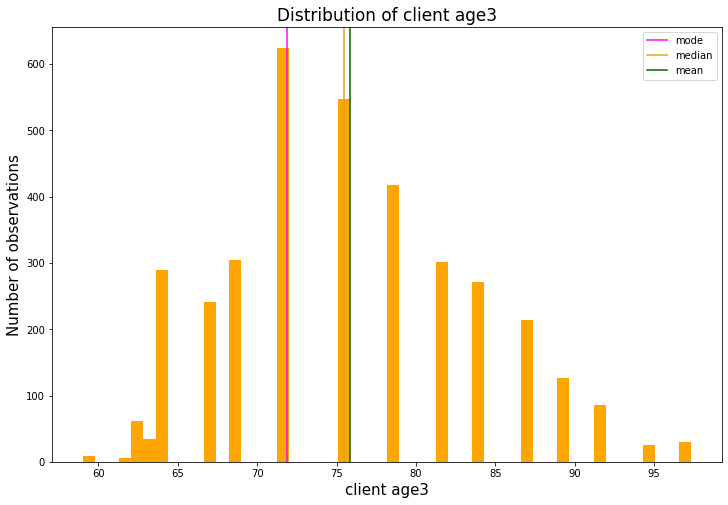

<Figure size 432x288 with 0 Axes>

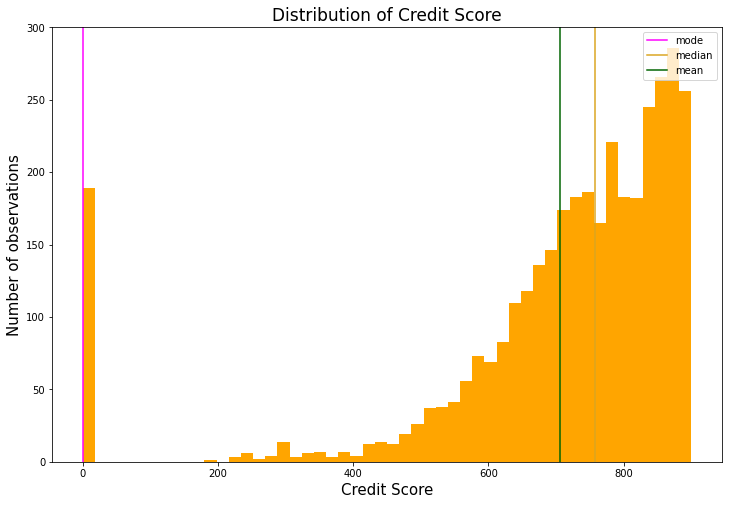

<Figure size 432x288 with 0 Axes>

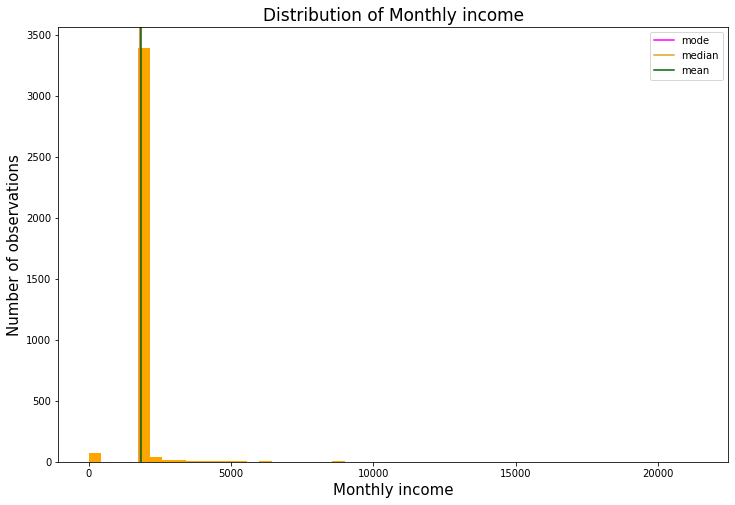

<Figure size 432x288 with 0 Axes>

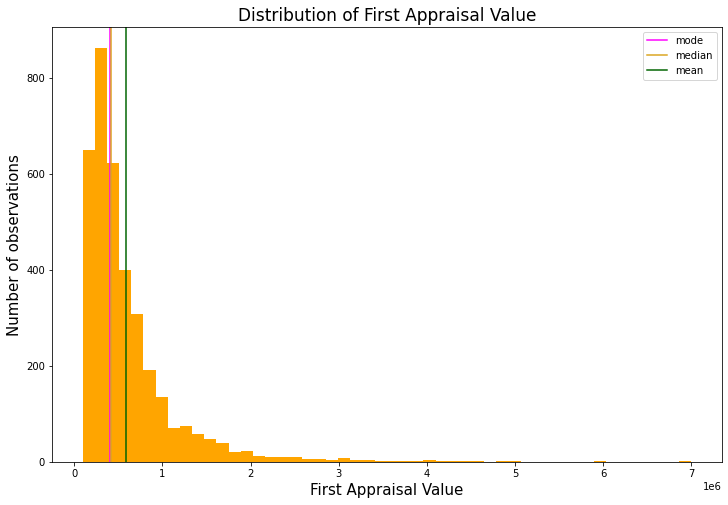

<Figure size 432x288 with 0 Axes>

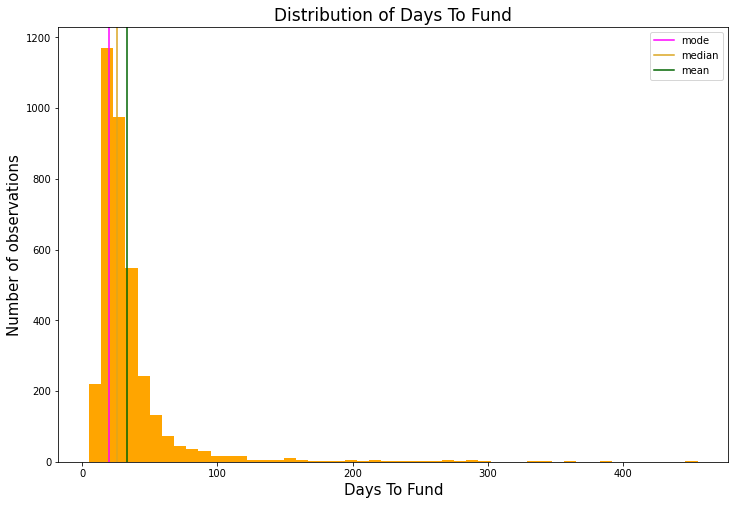

<Figure size 432x288 with 0 Axes>

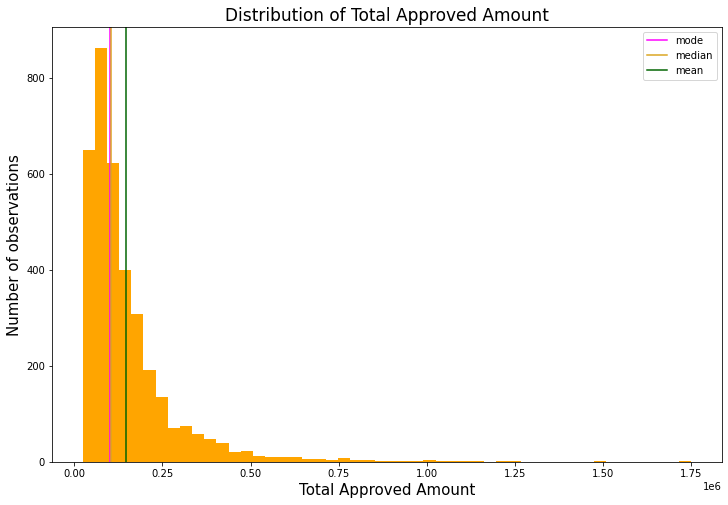

In [ ]:
# Distribution of numerical variables 

for i in numerical_variables:

  #Let's visualize our findings regarding the mosquito number and examnie how they are distirbuted.

  plt.figure()

  plt.figure(figsize=(12, 8))

  plt.hist(mortgages_data[i], bins=50,color='orange')
  plt.title(f'Distribution of {i}', size = 17)

  # Add the mode

  plt.axvline(mortgages_data[i].mode()[0], color='magenta', label='mode')

  # Add the median

  plt.axvline(mortgages_data[i].median(), color='goldenrod', label='median')

  # Add the mean

  plt.axvline(mortgages_data[i].mean(), color='darkgreen', label='mean')
  plt.legend(loc = 'upper right')
  plt.xlabel(f'{i}', size = 15)
  plt.ylabel('Number of observations', size = 15)


**Observations:**

All the numerical variables have a skewed distribution and obviously contain a great deal of outliers that we will have to treat later in this analysis.

These are the most important observations:
- most frequently, we deal with clients of around 72 years of age (mode) while the average age is around 75;
- the average credit score is above 700 indicating a high credit of our seniors;
- many of our clients don't enjoy much opulence of income, which centres around decent CAD 1,800 per month; 
- most of the properties offered for reverse mortgaging are below CAD 1 mln in appraisal values;
- although it has taken some clients more than a year to get funding for their property, most other properties get funded within 100 days (3 mo);
- since the approved amount is pegged to the house appraisal values (25%), the majority of approved amounts are below CAD 500 k.

### Distribution of First Appraisal Date and Funded Date

To understand better the distribution of First Appraisal Date and Funded Date, we decided to create a separate data frame that would allow us to isolate these values and prevent the contamination of the initial data frame while conducting exploratory data analysis and transformations.

In [ ]:
# Create a date - time data frame

date_time = mortgages_data[['First Appraisal Date', 'Funded Date']]

date_time['Month - Appraised'] = date_time['First Appraisal Date'].dt.strftime('%b').astype('category')
date_time['Month - Funded'] = date_time['Funded Date'].dt.strftime('%b').astype('category')

date_time = date_time.sort_values(by='First Appraisal Date', ascending=True)
order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

date_time.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Demonstrate the new data frame 

date_time.head(5)

,First Appraisal Date,Funded Date,Month - Appraised,Month - Funded
0,2016-03-21,2017-06-20,Mar,Jun
1,2016-03-31,2017-12-07,Mar,Dec
2,2016-04-04,2017-05-16,Apr,May
3,2016-04-19,2017-04-25,Apr,Apr
4,2016-05-12,2017-06-12,May,Jun


**Observation:**
- some loans, initiated in 2016, were funded in 2017.
- all loans initiated in 2017 were funded within that same year.

Let's create plots showing the distribution of the date-time variables.

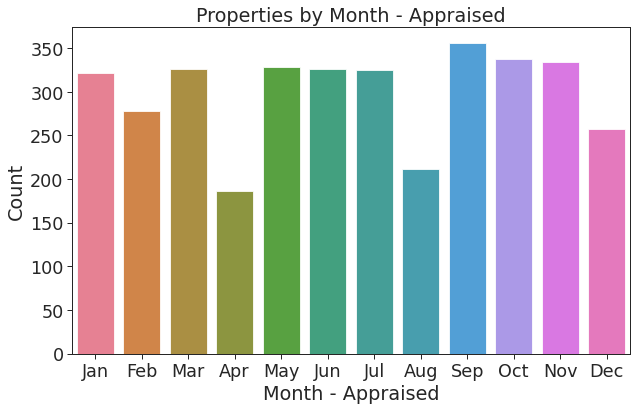

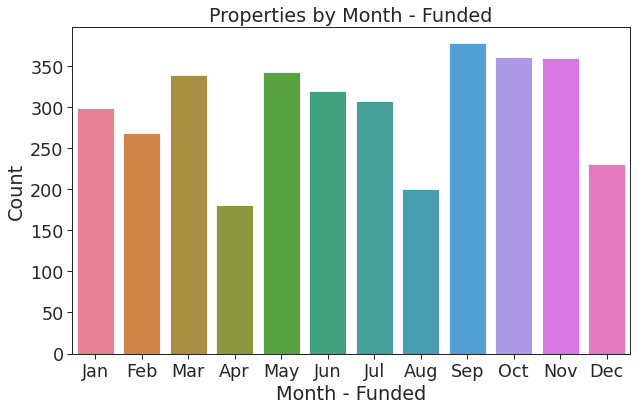

In [ ]:
# creating a plot - mosquitoes trapped by week 

for i in ['Month - Appraised',	'Month - Funded']:

  plt.figure(figsize=(10,6)) 
  sns.set_style("ticks")
  sns.set_context("paper", font_scale=2)

  sa = sns.barplot(x=date_time.sort_values(by=i).groupby(by=i).count().index, 
                  y=date_time[i].value_counts().sort_values(), data=date_time, palette = sns.color_palette("husl",12),
                  order=order)
  plt.ylabel('Count')
  sa.set(title = f'Properties by {i}' )

**Observation**:

- there is some mild cyclicity in the business, with every fourth month of the year showing a slight dip;
- the cyclicity may be attributed to the working of the internal bank's reporting systems.

# Treating the Outliers


The next step is outlier detection, which we will achieve through applying box plot mechanisms.

These are the columns that have proven to have outliers as a result of a visual inspection:

- client age3    
- Credit Score    
- Monthly income   
- First Appraisal Value  
- Days To Fund 
- Total Approved Amount  

We will examine these variables for outliers, except for Credit Score, because this feature is not subject to analyst assumptions. 

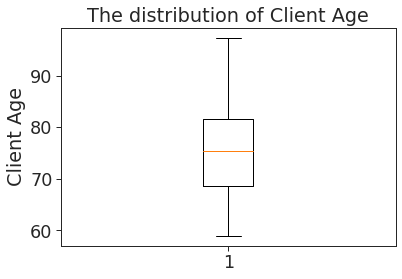

In [ ]:
# Age 

plt.figure()
plt.boxplot(mortgages_data['client age3'])
plt.title('The distribution of Client Age')
plt.ylabel('Client Age')
plt.show()

In [ ]:
# Age Outliers 

from matplotlib.cbook import boxplot_stats  
boxplot_stats(mortgages_data['client age3']).pop(0)['fliers']
len(boxplot_stats(mortgages_data['client age3']).pop(0)['fliers'])

0

In [ ]:
boxplot_stats(mortgages_data['client age3'])

[{'cihi': 75.82388455561363,
  'cilo': 75.13685447440946,
  'fliers': array([], dtype=float64),
  'iqr': 13.102411873840452,
  'mean': 75.8208420783563,
  'med': 75.48036951501155,
  'q1': 68.5469387755102,
  'q3': 81.64935064935065,
  'whishi': 97.33333333333333,
  'whislo': 59.0}]

The box plot method has shown no outliers, which counters the results of the visual inspection and confirms that the age of clients is distributed fairly normally, and we won't make any changes in our assumptions.

### Monthly income



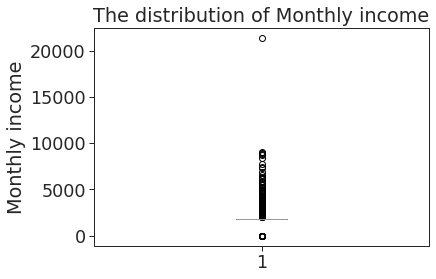

In [ ]:
# Monthly income 

plt.figure()
plt.boxplot(mortgages_data['Monthly income'])
plt.title('The distribution of Monthly income')
plt.ylabel('Monthly income')
plt.show()

In [ ]:
# Monthly Income Outliers 

from matplotlib.cbook import boxplot_stats  
boxplot_stats(mortgages_data['Monthly income']).pop(0)['fliers']
len(boxplot_stats(mortgages_data['Monthly income']).pop(0)['fliers'])

from matplotlib.cbook import boxplot_stats  

print(len(boxplot_stats(mortgages_data['Monthly income']).pop(0)['fliers']))
outliers = (boxplot_stats(mortgages_data['Monthly income']).pop(0)['fliers']).tolist()
outliers = set(outliers)
outliers = list(outliers) 
print(len(outliers))

199
123


The box plot method detects 199 instances and 123 unique outliers in the Monthly Income.

In [ ]:
# Show the distribution statistics for Monthly Income

boxplot_stats(mortgages_data['Monthly income'])

[{'cihi': 1800.0,
  'cilo': 1800.0,
  'fliers': array([    0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
     

We've identified 199 outliers consisting of 123 unique values. We will replace these values with the maximum amounts using the median of the Q3 from the box plot, which is CAD 1,800 in our case. The left end of the distribution we will treat the same way - by applying Q1.



In [ ]:
# Cure the outliers

mortgages_data['Monthly income'] = mortgages_data['Monthly income'].apply(lambda x: boxplot_stats(mortgages_data['Monthly income']).pop(0)['q3'] if x > boxplot_stats(mortgages_data['Monthly income']).pop(0)['q3'] else x)
mortgages_data['Monthly income'] = mortgages_data['Monthly income'].apply(lambda x: boxplot_stats(mortgages_data['Monthly income']).pop(0)['q1'] if x == 0.00 else x)


### Days To Fund

In [ ]:
# Days To Fund

from matplotlib.cbook import boxplot_stats  
boxplot_stats(mortgages_data['Days To Fund']).pop(0)['fliers']
len(boxplot_stats(mortgages_data['Days To Fund']).pop(0)['fliers'])

from matplotlib.cbook import boxplot_stats  

print(len(boxplot_stats(mortgages_data['Days To Fund']).pop(0)['fliers']))
outliers = (boxplot_stats(mortgages_data['Days To Fund']).pop(0)['fliers']).tolist()
outliers = set(outliers)
outliers = list(outliers) 
print(len(outliers))

269
107


There are 269 instances and 107 unique outliers in the Days To Fund.

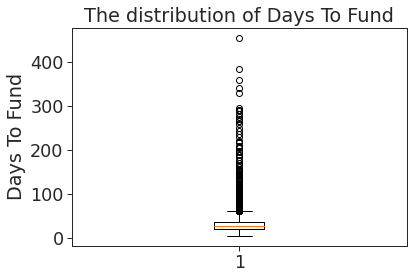

In [ ]:
# Days to Fund  

plt.figure()
plt.boxplot(mortgages_data['Days To Fund'])
plt.title('The distribution of Days To Fund')
plt.ylabel('Days To Fund')
plt.show()

In [ ]:
# Show Statistics for Days To Fund

boxplot_stats(mortgages_data['Days To Fund'])

[{'cihi': 26.44570081802227,
  'cilo': 25.55429918197773,
  'fliers': array([114,  78,  72,  65, 105,  70,  72, 130,  85, 122,  62,  69,  66,
          67,  93, 165, 188,  85,  74, 165,  79, 171,  79, 384, 195,  69,
          65,  63,  86, 107,  74, 106,  85,  84, 267,  75, 217, 117, 117,
          77,  82, 115, 185,  74,  86,  81,  86,  82,  79,  66,  80,  62,
          65,  86,  64, 330, 166, 102,  87,  63, 135, 107, 145,  96,  75,
          83, 237, 251, 177, 196, 155,  67,  75,  64, 116,  70, 171,  86,
          78,  65,  62, 151, 115,  86, 153, 135,  68, 155,  85,  67,  70,
          74,  77, 140, 292,  75,  69,  82,  75,  77,  85,  66,  84,  70,
          97,  73,  64,  64, 103, 105,  93,  74,  98,  68, 220,  71,  66,
          64,  78,  70,  62,  87,  65, 260, 111,  64,  83,  69,  87, 145,
         107,  72, 108,  86,  68, 154,  70,  65,  81,  97,  89,  66, 154,
         292,  87, 210, 218, 270, 104, 107, 129,  78, 218, 359,  68,  68,
         118, 198,  83, 266,  97, 101,  98, 

We will cure the outliers in this variable because they are present in less than 10% of cases, and it will not cause any serious distortion of the data set. The cure is only needed on the right side of the distribution. 

Separately, we note that, currently, the median value of Days To Fund is **26** and the median is around **33**.

In [ ]:
# cure the outliers 

mortgages_data['Days To Fund'] = mortgages_data['Days To Fund'].apply(lambda x: boxplot_stats(mortgages_data['Days To Fund']).pop(0)['whishi'] if x > boxplot_stats(mortgages_data['Days To Fund']).pop(0)['whishi'] else x)


### First Appraisal Value

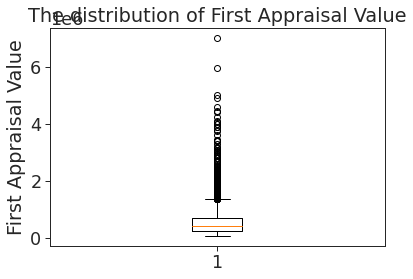

In [ ]:
# First Appraisal Value 

plt.figure()
plt.boxplot(mortgages_data['First Appraisal Value'])
plt.title('The distribution of First Appraisal Value')
plt.ylabel('First Appraisal Value')
plt.show()

In [ ]:
# First Appraisal Value 

from matplotlib.cbook import boxplot_stats  
boxplot_stats(mortgages_data['First Appraisal Value']).pop(0)['fliers']
len(boxplot_stats(mortgages_data['First Appraisal Value']).pop(0)['fliers'])

from matplotlib.cbook import boxplot_stats  

print(len(boxplot_stats(mortgages_data['First Appraisal Value']).pop(0)['fliers']))
outliers = (boxplot_stats(mortgages_data['First Appraisal Value']).pop(0)['fliers']).tolist()
outliers = set(outliers)
outliers = list(outliers) 
print(len(outliers))

257
118


There are 257 outliers in the First Appraisal Value and 118 unique instances.

In [ ]:
# Show statistics for First Appraisal Value

boxplot_stats(mortgages_data['First Appraisal Value'])

[{'cihi': 431436.1586365479,
  'cilo': 408563.8413634521,
  'fliers': array([1900000, 2400000, 1390000, 3625000, 1475000, 1840000, 1420000,
         3150000, 1670000, 2000000, 2525000, 1580000, 1430000, 2050000,
         1575000, 1495000, 1443000, 1980000, 1600000, 3750000, 1700000,
         1500000, 1710000, 1875000, 1425000, 1500000, 1975000, 2450000,
         3150000, 1580000, 1830000, 1760000, 1950000, 2700000, 1615000,
         1775000, 1850000, 1675000, 2796000, 1700000, 1400000, 1890000,
         1880000, 1575000, 2500000, 2150000, 1440000, 1710000, 4600000,
         3000000, 3100000, 1385000, 1400000, 1575000, 1460000, 1800000,
         3300000, 1535000, 2000000, 2500000, 2325000, 1550000, 1530000,
         2000000, 1700000, 1650000, 2000000, 1400000, 1675000, 2950000,
         2400000, 1800000, 2405000, 2100000, 1750000, 1400000, 1600000,
         2800000, 1690000, 1390000, 1525000, 2800000, 1850000, 1500000,
         2180000, 3430000, 3050000, 4400000, 1630000, 1600000, 44500

We will cure the outliers using the box plot method and cap the appraisal value at Q3, which in our case is CAD 1,360,000.

In [ ]:
# Cure the outliers 

mortgages_data['First Appraisal Value'] = mortgages_data['First Appraisal Value'].apply(lambda x: boxplot_stats(mortgages_data['First Appraisal Value']).pop(0)['whishi'] if x > boxplot_stats(mortgages_data['First Appraisal Value']).pop(0)['whishi'] else x)


# Total Approved Amount

After curing the First Appraisal Amount, we should create a separate column that would contain the data of the maximum approved amount, given the fact that it is pegged to the First Appraisal Amount.

In [ ]:
# correct Total Approved Amount for the outliers that were removed from the appraisal amount

mortgages_data['Total Approved Amount_corrected_'] = 0.25*mortgages_data['First Appraisal Value']

# Most Recent Default Date

The Most Recent Default Date will be converted into a new variable that we will call 'Default Status'. The latter will be the target variable, and 1 in it will signify an instance of default, while 0 signifies the opposite.

In [ ]:
# Most Recent Default Date

for i in ['Most Recent Default Date']:
  mortgages_data[i] = mortgages_data[i].astype('str')
  #mortgages_data[i] = mortgages_data[i].replace('NaT', np.nan)
  #mortgages_data[i]  = mortgages_data[i].fillna(0, inplace = True)
  # mortgages_data['Most Recent Default Date'] = mortgages_data['Most Recent Default Date'].fillna(0, inplace = True)
  # mortgages_data['Most Recent Default Date'] = mortgages_data['Most Recent Default Date']


In [ ]:
# Create Default Status column and mark the classes

mortgages_data['Most Recent Default Date'] = mortgages_data['Most Recent Default Date'].apply(lambda x: 0 if x == 'NaT' else 1) 
mortgages_data['Default Status'] = mortgages_data['Most Recent Default Date']

In [ ]:
# Check the number of rows in which the Total Approved Amount has been corrected due to the mormalization of the Appraisal Amount - 257 - all matches 

mortgages_data.loc[~(mortgages_data['Total Approved Amount'] == mortgages_data['Total Approved Amount_corrected_'])]

,POA / Influencer,Property Type,City,Province,client age3,Credit Score,Monthly income,First Appraisal Date,First Appraisal Value,Funded Date,Days To Fund,Total Approved Amount,Most Recent Default Date,Total Approved Amount_corrected_,Default Status
5,No,Single Family Dwelling,Thornhill,Ontario,64.228571,834.500000,1800.0,2017-07-03,1360000,2017-07-28,25,475000.0,0,340000.0,0
16,No,Condo - Apartment Style,Toronto,Ontario,84.014851,753.666667,1800.0,2017-07-28,1360000,2017-10-06,50,600000.0,0,340000.0,0
19,No,Single Family Dwelling,Coquitlam,British Columbia,81.649351,791.666667,1800.0,2017-08-08,1360000,2017-08-28,18,347500.0,0,340000.0,0
25,Yes,Single Family Dwelling,Vancouver,British Columbia,81.649351,849.000000,1800.0,2017-11-20,1360000,2017-12-19,23,906250.0,0,340000.0,0
35,No,Single Family Dwelling,Markham,Ontario,81.649351,827.000000,1800.0,2017-11-07,1360000,2017-12-11,30,368750.0,0,340000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,No,Single Family Dwelling,Toronto,Ontario,75.480370,732.333333,1800.0,2017-04-24,1360000,2017-05-15,13,493750.0,1,340000.0,1
3541,No,Single Family Dwelling,Toronto,Ontario,84.014851,264.333333,1800.0,2017-09-21,1360000,2017-11-28,45,350000.0,0,340000.0,0
3542,Yes,Single Family Dwelling,Vancouver,British Columbia,84.014851,894.000000,1800.0,2017-09-21,1360000,2017-10-20,24,475000.0,0,340000.0,0
3544,No,Mobile Home,Langley,British Columbia,63.153846,617.000000,1800.0,2017-10-31,1360000,2017-11-28,32,405000.0,0,340000.0,0


The below helps us ensure that the Total approved amount won't exceed the 25% peg.

In [ ]:
round(100*mortgages_data['Total Approved Amount_corrected_']/mortgages_data['First Appraisal Value'],2).mean()

25.0

If we examine the prevalence of default by city, we don't observe any significant spikes, and the largest cities expectedly have more instances of default simply as a function of their size.

In [ ]:
# Split of defaults per city

mortgages_data[mortgages_data['Default Status'] == 1]['City'].value_counts()

Toronto           37
Calgary           22
Edmonton          18
Montreal          14
Mississauga       13
                  ..
Chatham            1
Qualicum Beach     1
Whitby             1
Oka                1
Coleman            1
Name: City, Length: 261, dtype: int64

### A Glimpse into Credit Score

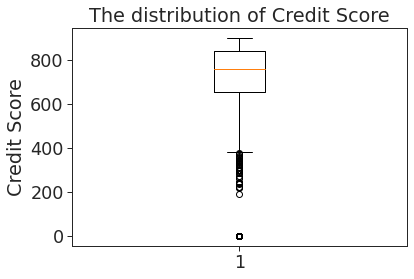

In [ ]:
# Distribution of Credit Score

plt.figure()
plt.boxplot(mortgages_data['Credit Score'])
plt.title('The distribution of Credit Score')
plt.ylabel('Credit Score')
plt.show()

In [ ]:
# Show boxplot statistics for Credit Score 

boxplot_stats(mortgages_data['Credit Score'])

[{'cihi': 761.8240559127116,
  'cilo': 752.1759440872884,
  'fliers': array([  0.        ,   0.        , 361.        ,   0.        ,
           0.        ,   0.        , 372.        , 283.66666667,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        , 352.        ,   0.        ,
           0.        , 342.5       ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
         327.5       ,   0.        ,   0.        ,   0.        ,
         295.5       ,   0.        ,   0.        ,   0.        ,
         300.        , 300.        ,   0.        ,   0.        ,
         306.5       ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        , 240.66666667,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
         300.        ,   0.        , 219.        ,   0.        ,
           0.        ,

Based on the statistics, we will consider 655 credit score as the left-hand side cut-off for auto-adjudication, as it is still a decent score which we know to be associated with no-default.

# Feasibility Analysis 

#### **List of Assumptions**

- 12.29% - an expected growth rate for the coming 5 years (based on the previous 5 years of data);
- 26 days - an average number of days to get funding now;
- $500 k - the maximum cost of implementation of the project (excluding sunk costs such as the salaries of the staff already working);
- 0.5 h - the time required by a credit officer to review and approve a mortgage loan request;
- CAD 100 k - the salary of a credit officer per annum;
- 5% - a long-term growth rate;
- 40 h per week - length of a working week of a credit officer;
- 52 weeks - the number of weeks per year;
- 13% - the cost of capital of the bank and the appropriate discount rate;
- 5 years - the project's life cycle.





**Feasibility Analysis**

Our business opportunity involves using the momentum to capture a larger chunk of the almost untouched reverse mortgage pie while the space is not yet filled with the competition. 

We might be able to achieve this by providing our clients with the best customer experience.

As we know from the above, it takes us on average 26 days to fund a mortgage (a median). By employing auto-adjudication, we might be able to shorten this by 2 days. 

The question is thus, "How feasible is it to process our reverse mortgage loan requests through auto-adjudication?"

The **feasibility analysis** typically requires answering the following questions:
- Do we have the technology to be able to do this? - In our case, the answer is YES.
- Do we have people resources? - We might leverage our internal risk management resources, business analysts and a third-party vendor to create systems that would perform auto-adjudication. The costs of building and implementation might vary from US250 k to US500 k (this assumption should be verified against concrete vendor proposals), excluding service costs.
- What ROI does this project yield? -To answer this question, we need to perform further analysis.
- What is the project's life cycle? - Since the space is fast-paced, we will look only at the coming 5 years.

**Steps**

We will skip some of the traditional steps that comprise a feasibility study, because they are not yet relevant to us at this point. However, we will focus on the most crucial aspects of the feasibility study that will give us a glimpse into what we might expect if we decide to implement the auto-adjudication:

- Conduct a high-level market analysis;
- Discuss the project's tangible/intangible values; 
- Discuss the project's ROI and NPV;
- Discuss the recommendations.






**Market Analysis**

We conducted a high-level market analysis and included it in a separate file attached to this document.

**Tangible Value**

The project's tangible value will transpire due to additional savings and earnings.

The **savings** component of the tangible value shall come about due to the increased ability of the existing operational and risk-management staff to review and decide upon higher volumes of credit dossiers, which is expected to continue growing at 12.3% p.a. 

Another part of the savings component includes the savings from engagement in handling potential default on behalf of the client. Contemporary machine learning models (KNN, Logistic Regression, and Decision Trees) are believed to be capable of helping the bank take more careful decisions that in the future will lead to fewer default events and thus create savings for the bank.

The **earnings** component consists of additional NII that the bank is able to book earlier in the year and increased throughput (the ability to process and approve larger volumes of loans). 

The Intangible value of the project shall transpire due to the positive impact of this offering on the bank's marketing effort and increased brand-recognition due to the application of this technology.

**A Brief Description of Auto-Adjudication**

Before we decide to implement the process, we should set the conditions that might be followed for it. These conditions are subject to a rigorous testing by the risk department and compliance to ensure their adherence to the existing regulation.

**Which Mortgages Might be Subject to Auto-Adjudication:**

- the appraisal amount below CAD 1,360,000 (the high end of the distribution of house prices that we've previously worked with, after curing the few outliers); 
- the monthly income is equal to or exceeds CAD 1,800 (median);
- the age does not exceed 81 years (75% percentile) considering the life expectancy in this country being 81 years of age.
- credit score does not fall below 655.0, which is Q1 and 'fair credit'.
- No conditions apply to 'POA / Influencer', 'Property Type', 'City' or 'Province'.

**Approval by Credit Officer:**
- any requests which violate one or more conditions for Auto-Adjudication are subject to a manual review by a credit officer;
- a suggestion (approve/reject) by a machine learning algorithm can and should be taken into account by the credit officer when taking a final decision on a credit request that violates the auto-adjudication conditions.






### Financial Projection

In [ ]:
# Financial projection

count_mortgages_2017 = mortgages_data[mortgages_data['First Appraisal Date'] >= '2017-01-01']['First Appraisal Date'].value_counts().sum()

# Count hours spent on approvals assuming 30 mins per application 

hours_spent_on_approvals = 0.5*count_mortgages_2017
print(hours_spent_on_approvals)

person_hours_required_staff_p_a = hours_spent_on_approvals/(52*40)
print(person_hours_required_staff_p_a)

1681.0
0.8081730769230769


If 30 minutes is required on average to approve a loan manually, the total volume of mortgage loans approved by the bank in 2017 required 1681 hours of time of credit officer work, which is roughly 80% of the entire amount of working hours one credit officer works per year.

In [ ]:
# Percentage of Loans that Could Go through Auto-Adjudication

count_mortgages_2017_auto_adj = mortgages_data[(mortgages_data['First Appraisal Date'] >= '2017-01-01') & 
                                               (mortgages_data['First Appraisal Value'] <= 1360000) & (mortgages_data['Monthly income'] >=1800) & (mortgages_data['Credit Score']>=655)]['First Appraisal Date'].value_counts().sum()
pct_auto_adj_2017 = count_mortgages_2017_auto_adj/count_mortgages_2017
print(f'{round(100*pct_auto_adj_2017,2)}, %')

76.62, %


If we check the entire volume of mortgage loans that were approved in 2017 against the conditions for auto-adjudication, we realize that 76.62% of those loans could have been approved automatically.

In [ ]:
# amount of hours needed from Credit officers given auto-adjudication

person_hours_required_staff_p_a_given_auto_adj = (hours_spent_on_approvals-hours_spent_on_approvals*pct_auto_adj_2017)
person_hours_required_staff_p_a_given_auto_adj # a significant time saving 

393.0

The remaining mortgage loan requests that were subject to manual approval by a credit officer would have required 293 hours of credit officer work, which is significantly less than what was required without auto-adjudication. 

In [ ]:
# Hours that could be spent through  auto-adjudication 

hours_spent_on_approvals*pct_auto_adj_2017

1288.0

In other words, auto-adjudication would have saved the bank 1288 hours of credit officer work that could have been spent on other important tasks that matter for the success of the organization. 

#### Saving on Credit Officer Salary

In [ ]:
# Credit Officer Salary 

salary_credit_officer_per_annum = 100000
salary_credit_officer_per_hour = salary_credit_officer_per_annum/(52*5*8) # salary of a credit officer per hour 
savings_2017 = salary_credit_officer_per_hour*hours_spent_on_approvals*pct_auto_adj_2017

print(salary_credit_officer_per_hour)
print(savings_2017)

48.07692307692308
61923.07692307694


An hourly wage of a credit officer is ~CA 48. That will translate into a saving of CAD 61k in terms of working hours. There are many ways how this can be realized, but the most obvious way is to not hire additional resources and have the existing staff perform more work since they will have the time available at hand.

#### Additional Interest Marging 

Obviously, if during 2017 the auto-adjudication process was in place, the bank could have saved 2 days on most loans and book extra interest income in 2017 for those 2 days. Below, we will attempt to estimate the difference that it would have made in terms of interest margin.

In [ ]:
# Calculate the number of days that the mortgages could have been used in total in 2017 due to auto-adjudication

total_days_saved = 2*count_mortgages_2017_auto_adj 
total_amount_auto_adj_mortgages = mortgages_data[(mortgages_data['First Appraisal Date'] >= '2017-01-01') & 
                                               (mortgages_data['First Appraisal Value'] <= 1360000) & (mortgages_data['Monthly income'] >=1800) & (mortgages_data['Credit Score']>=655)]['Total Approved Amount_corrected_'].sum()

from datetime import datetime

mortgages_data_earnings = mortgages_data.copy() 

mortgages_data_earnings['Additional_int_margin_with_auto_adj_2017'] = 0

date_start = mortgages_data_earnings['Funded Date']
date_end = '2018-01-01'
date_end = datetime.strptime(date_end, "%Y-%m-%d")

mortgages_data_earnings['Days_mortgage_used_2017'] = date_end - mortgages_data_earnings['Funded Date']
mortgages_data_earnings['Days_mortgage_used_2017'] = mortgages_data_earnings['Days_mortgage_used_2017'].astype('timedelta64[D]') # number of days the mortgage was used for in 2017

In [ ]:
# Calculate the number of days for each mortgage that it would have been used for during 2017 given auto-adjudication 

mortgages_data_earnings['Days_mortgage_used_2017_after_auto_adj'] = mortgages_data_earnings['Days_mortgage_used_2017'] + 2
mortgages_data_earnings['Days_mortgage_used_2017_after_auto_adj']

0        40.0
1        16.0
2        33.0
3        13.0
4       322.0
        ...  
3590     65.0
3591     57.0
3592    250.0
3593    258.0
3594    268.0
Name: Days_mortgage_used_2017_after_auto_adj, Length: 3586, dtype: float64

The above column demonstrates the number of days each mortgage loan would have been used in 2017 if it had been approved via auto-adjudication. 

In [ ]:
# Calculate additional interest margin that could have been realized in 2017 due to auto-adjudication 

NII = 0.04
NII_daily = (NII/365)**(1) # compound NII per day

mortgages_data_earnings['Additional_int_margin_with_auto_adj_2017'] = mortgages_data_earnings['Total Approved Amount_corrected_']*(1+NII_daily)**(2) - mortgages_data_earnings['Total Approved Amount_corrected_']

earnings_2017 = mortgages_data_earnings['Additional_int_margin_with_auto_adj_2017'].sum()
print(earnings_2017)


105422.55467267857


The above calculation shows, that given our assumptions, the additional two days of  utilization by auto-adjudicated mortgage loans could have yielded more than CA$ 105 k of additional interest margin in 2017. 

#### Calculate the NPV of the Project 

In [ ]:
# NPV of the project - create a data dictionary 

npv_dict = {'Year': ['2017', '2018', '2019', '2020', '2021'] , 'Investment (CAD)' : [-500000*1.26, 0, 0, 0, 0],  'Savings (CAD)': [savings_2017, 0, 0, 0, 0], 'Earnings (CAD)': [earnings_2017, 0, 0, 0, 0], 'Total (CAD)': [0,0,0,0,0]}

In [ ]:
# Create NPV table 

project_forecast = pd.DataFrame.from_dict(npv_dict, orient='index')
new_header = project_forecast.iloc[0] 
project_forecast = project_forecast[1:] 
project_forecast.columns = new_header

projected_CAGR = 0.1229 #from our assumptions 

In [ ]:
# extrapolate the 2017 data given the expected growth rate (CAGR) 

for i in enumerate(['2017', '2018', '2019', '2020']):
  def extrapol(x, CAGR): 
    return x *(1+projected_CAGR)
  value = extrapol(project_forecast.iloc[:, (i[0])]['Earnings (CAD)'], CAGR=projected_CAGR)
  project_forecast.iloc[:,(i[0]+1)]['Earnings (CAD)'] = value

  value = extrapol(project_forecast.iloc[:, (i[0])]['Savings (CAD)'], CAGR=projected_CAGR)
  project_forecast.iloc[:,(i[0]+1)]['Savings (CAD)'] = value

for i in enumerate(['2017', '2018', '2019', '2020', '2021']):
  project_forecast.iloc[:, (i[0])]['Total (CAD)'] = project_forecast.iloc[:,(i[0])]['Earnings (CAD)'] + project_forecast.iloc[:,(i[0])]['Savings (CAD)'] 


project_forecast

Year,2017,2018,2019,2020,2021
Investment (CAD),-630000,0,0,0,0
Savings (CAD),61923.1,69533.4,78079.1,87675,98450.3
Earnings (CAD),105423,118379,132928,149265,167609
Total (CAD),167346,187912,211007,236940,266059


In [ ]:
# Rates assumptions 

g = 0.05 #(long-term growth rate)
r = 0.13 # the actual discount should be equal to the bank's return on capital which we don't know 
cap_rate = r - g  

# Terminal value of the project 

terminal_value = (project_forecast.iloc[:, 4]['Total (CAD)']**(1+g))/cap_rate

In [ ]:
# Make a list of values and include the terminal value in the list at the end summing it with the last value 

total_cad = project_forecast.iloc[3].tolist()

total_cad_2021 = project_forecast.iloc[:, 4]['Total (CAD)']
total_cad.pop(4)
total_cad.append(total_cad_2021 + terminal_value)

In [ ]:
# Calculate the project's NPV

npv_project = np.npv(r,total_cad)
print(f' CAD {round(npv_project, 2)}, which is equivalent to USD {round(npv_project, 2)*0.79}')

 CAD 4635392.6, which is equivalent to USD 3661960.154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).
  This is separate from the ipykernel package so we can avoid doing imports until


The above calculation shows that the NPV of the project exceeds CAD 4.6 mln even given the conservative terminal growth estimations and discount rate. 

In [ ]:
# Calculate the total gain

total_gain = 0
list_total_cad = project_forecast.iloc[3].tolist()

for element in range(0, len(list_total_cad)):
    total_gain = total_gain + list_total_cad[element]

In [ ]:
# ROI

ROI = round((-1)*total_gain/project_forecast.iloc[:, 0]['Investment (CAD)'],2)

ROI

1.7

The calculation shows that the ROI of the project given the projected level of investment shall be around 1.7, which signifies a profitable project.

[Text(0.5, 1.0, 'Economic Benefit from Auto-Adjudication')]

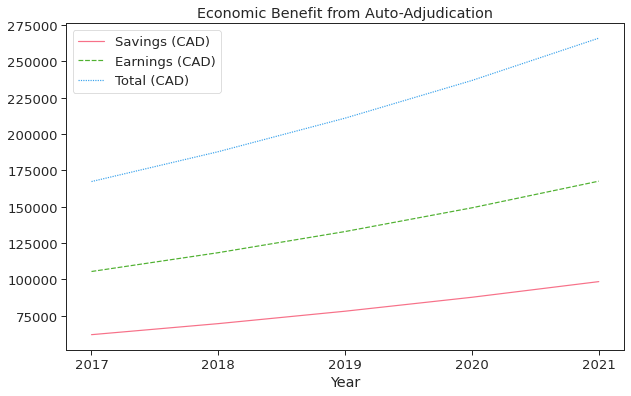

In [ ]:
# Plot the Savings, Earnings and Total 

import seaborn as sns

plt.figure(figsize=(10,6)) 
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
savings_earnings = sns.lineplot(data = project_forecast.T[['Savings (CAD)', 'Earnings (CAD)', 'Total (CAD)']], palette = sns.color_palette("husl",3))
savings_earnings.set(title = 'Economic Benefit from Auto-Adjudication')

### **Machine Learning Models** 

#### **Feature Engineering**

Since we know that the bank won't finance properties at more than 25% LTV, we should check if this rule has been followed in the previous periods.

In [ ]:
# Create a set for Modelling and drop the columns that are no longer important 

train_test_mortgages = mortgages_data.drop(columns = ['First Appraisal Date',	'First Appraisal Value',	'Funded Date', 'Days To Fund', 'Total Approved Amount'])

In [ ]:
# Get dummies from categorical variables and drop the first columns of each dummified value to reduce dimentionality 

train_test_mortgages = pd.get_dummies(train_test_mortgages, columns = ['POA / Influencer', 'Property Type', 'Province', 'City'], drop_first=True)

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create features 

X = train_test_mortgages.drop(columns = 'Default Status')
y = train_test_mortgages['Default Status']

# Summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 3067, 1: 519})


Above, we dropped the unimportant variables and created dummies of those that are of interest for our machine learning models. 

In [ ]:
# Transform the dataset and handle the class imbalance
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# Summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 3067, 1: 3067})


Above, we have applied a machine learning technique to balance the 'default' and no-default classes in the data-set.

In [ ]:
# split the data set into train and test conventionally - 70% train and 30% test

# Train-Test-Split the data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)

### KNN model 

In [ ]:
# knn

#Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Create a KNN model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split our data into train & test sets

accuracy_score_KNN = []

for i in range(3,30,1):

  # Instantiate the model & fit it to our data
  KNN_model = KNeighborsClassifier(n_neighbors=i)
  KNN_model.fit(X_train, y_train)

  # Score the model on the test set
  test_predictions = KNN_model.predict(X_test)
  test_accuracy = accuracy_score(test_predictions, y_test)
  print(f"Test set accuracy: {test_accuracy}")
  accuracy_score_KNN.append(test_accuracy)

# Choose the best model
k_optimal = accuracy_score_KNN.index(max(accuracy_score_KNN))+1
KNN_model = KNeighborsClassifier(n_neighbors=k_optimal)
KNN_model.fit(X_train, y_train)
test_predictions = KNN_model.predict(X_test)

Test set accuracy: 0.8397609994568169
Test set accuracy: 0.8354155350353069
Test set accuracy: 0.8142313959804454
Test set accuracy: 0.8174904942965779
Test set accuracy: 0.8055404671374253
Test set accuracy: 0.8055404671374253
Test set accuracy: 0.7876154263986963
Test set accuracy: 0.7843563280825638
Test set accuracy: 0.7702335687126561
Test set accuracy: 0.7653449212384573
Test set accuracy: 0.7544812601846822
Test set accuracy: 0.7512221618685497
Test set accuracy: 0.7409016838674634
Test set accuracy: 0.7403585008147746
Test set accuracy: 0.7256925583921782
Test set accuracy: 0.7267789244975557
Test set accuracy: 0.717001629549158
Test set accuracy: 0.7164584464964693
Test set accuracy: 0.7175448126018468
Test set accuracy: 0.717001629549158
Test set accuracy: 0.710483432916893
Test set accuracy: 0.7088538837588267
Test set accuracy: 0.6969038565996741
Test set accuracy: 0.6963606735469854
Test set accuracy: 0.686040195545899
Test set accuracy: 0.6844106463878327
Test set accurac

In [ ]:
# classification report and confusion matrix - KNN

print(classification_report(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       927
           1       0.82      0.94      0.88       914

    accuracy                           0.87      1841
   macro avg       0.88      0.87      0.87      1841
weighted avg       0.88      0.87      0.87      1841

[[735 192]
 [ 52 862]]


The KNN model performed well overall, capturing 94% of instances of default and can reliably be used for taking reverse mortgage loans decision based on the client input data.

#### Logistic Regression Model

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000, C=0.001) 
log_reg_model.fit(X_train, y_train)

log_reg_model_train_score = log_reg_model.score(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

log_reg_model_test_score = log_reg_model.score(X_test, y_test)


print(f'Accuracy score for the logistic regression - train score: {log_reg_model_train_score:.3f}')
print(f'Accuracy score for the logistic regression - test score: {log_reg_model_test_score:.3f}')

print('Logistic Regression - Classification Report')   
print(classification_report(y_test, y_pred))

Accuracy score for the logistic regression - train score: 1.000
Accuracy score for the logistic regression - test score: 0.997
Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       927
           1       1.00      1.00      1.00       914

    accuracy                           1.00      1841
   macro avg       1.00      1.00      1.00      1841
weighted avg       1.00      1.00      1.00      1841



The logistic regression model performed better than KNN, identifying 0.997 percent of default instances that is very accurate and reliable and should be preferred to KNN.

### Decision Trees

In [ ]:
# perform the best parameters for Decision Trees 

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_depth': list(range(2, 20,1)), 'min_samples_leaf': list(range(1,20, 1))} 
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=5)

grid_search_cv.fit(X_train, y_train)
grid_mortgages = grid_search_cv.best_estimator_

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


In [ ]:
print(grid_mortgages)

DecisionTreeClassifier(max_depth=2, random_state=42)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# the ideal models 

grid_mortgages.fit(X_train, y_train)

print(f'Train accuracy score - train set: {grid_mortgages.score(X_train, y_train):.3f}')
print(f'Test accuracy score - train set: {grid_mortgages.score(X_test, y_test):.3f}')

print(classification_report(y_test, grid_mortgages.predict(X_test) ))
print(confusion_matrix(y_test, grid_mortgages.predict(X_test) ))


Train accuracy score - train set: 1.000
Test accuracy score - train set: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       927
           1       1.00      1.00      1.00       914

    accuracy                           1.00      1841
   macro avg       1.00      1.00      1.00      1841
weighted avg       1.00      1.00      1.00      1841

[[927   0]
 [  0 914]]


Based on the above, Decision Trees demonstrated the best performance, having identified 100% of potentially defaulting loans. It is the model of choice for the auto-adjudication purposes. 